In [30]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import networkx as nx
import itertools

# 1. DATA

First of all we decompressed the '.gz' files and then added a row as a header ('from to time').

In [3]:
#load data
answers_to_questions = pd.read_table('../Downloads/answers_to_questions.txt', sep=' ')
comments_to_answers = pd.read_table('../Downloads/comments_to_answers.txt', sep=' ')
comments_to_questions = pd.read_table('../Downloads/comments_to_questions.txt', sep=' ')

In [4]:
answers_to_questions.head()

,from,to,time
0,9,8,1217567877
1,1,1,1217573801
2,13,1,1217606247
3,17,1,1217617639
4,48,2,1217618182


If you wanna work on a smaller range of time use the code below. For example let's just take the data from 2010.

In [5]:
#create timestamps for the first and last days of 2010
import time
start = '01/01/2010'
end = '31/12/2010'
start = int(time.mktime(datetime.datetime.strptime(start, "%d/%m/%Y").timetuple()))
end = int(time.mktime(datetime.datetime.strptime(end, "%d/%m/%Y").timetuple()))


#take only data from the first half of 2009
answers_to_questions = answers_to_questions[(answers_to_questions.time >= start) & (answers_to_questions.time <= end)]
comments_to_answers = comments_to_answers[(comments_to_answers.time >= start) & (comments_to_answers.time <= end)]
comments_to_questions = comments_to_questions[(comments_to_questions.time >= start) & (comments_to_questions.time <= end)]
#reset the index
answers_to_questions.reset_index(drop = True, inplace = True)
comments_to_answers.reset_index(drop = True, inplace = True)
comments_to_questions.reset_index(drop = True, inplace = True)

Let's deal with dates!

In [6]:
#convert timestamps
answers_to_questions['time'] = answers_to_questions['time'].apply(datetime.datetime.fromtimestamp).astype(str)
comments_to_answers['time'] = comments_to_answers['time'].apply(datetime.datetime.fromtimestamp).astype(str)
comments_to_questions['time'] = comments_to_questions['time'].apply(datetime.datetime.fromtimestamp).astype(str)

#let's just take year, month, day (in this order)
answers_to_questions['time'] = answers_to_questions['time'].str[:10]
comments_to_answers['time'] = comments_to_answers['time'].str[:10]
comments_to_questions['time'] = comments_to_questions['time'].str[:10]

In [7]:
answers_to_questions.head()

,from,to,time
0,235648,46724,2010-01-01
1,232279,117859,2010-01-01
2,235648,147095,2010-01-01
3,79668,73630,2010-01-01
4,202019,46724,2010-01-01


In [8]:
comments_to_answers.head()

,from,to,time
0,87834,85597,2010-01-01
1,164506,45914,2010-01-01
2,222908,187606,2010-01-01
3,71134,71134,2010-01-01
4,241577,133910,2010-01-01


In [9]:
comments_to_questions.head()

,from,to,time
0,1831,229728,2010-01-01
1,144424,147095,2010-01-01
2,121363,198729,2010-01-01
3,30587,86288,2010-01-01
4,231677,31699,2010-01-01


Each dictionary represents a adjacency list. 

The dictionary *Graph* represent the merge of the 3 single graphs: for each node *u* there are all the nodes *v* , represented as dictionaries, which answered to a question of node *u*, commented an answer of node *u* or commented a question of node *u*. This graph is directed and self-connections are allowed. Each dictionary represented by the nodes *v* cointains a list of all the dates of the actions.

We can think at the dictionary *Graph* as am adjacency list. Moreover each link is weigthed, and the weight is equal to the number of actions taken, which can be calculated by taking the length of the list inside each dictionary *v*.

In [10]:
answers_to_questions_graph = {}

for i in range(len(answers_to_questions)):
    if answers_to_questions['from'][i] not in answers_to_questions_graph:
        answers_to_questions_graph[answers_to_questions['from'][i]] = []
    answers_to_questions_graph[answers_to_questions['from'][i]].append((answers_to_questions.to[i], answers_to_questions.time[i]))
    
    
for key in answers_to_questions_graph.keys():
    supp = {}
    for i in range(len(answers_to_questions_graph[key])):
        if answers_to_questions_graph[key][i][0] not in supp:
            supp[answers_to_questions_graph[key][i][0]] = []
        supp[answers_to_questions_graph[key][i][0]].append(answers_to_questions_graph[key][i][1])
    answers_to_questions_graph[key] = supp

In [11]:
comments_to_answers_graph = {}

for i in range(len(comments_to_answers)):
    if comments_to_answers['from'][i] not in comments_to_answers_graph:
        comments_to_answers_graph[comments_to_answers['from'][i]] = []
    comments_to_answers_graph[comments_to_answers['from'][i]].append((comments_to_answers.to[i], comments_to_answers.time[i]))
    


for key in comments_to_answers_graph.keys():
    supp = {}
    for i in range(len(comments_to_answers_graph[key])):
        if comments_to_answers_graph[key][i][0] not in supp:
            supp[comments_to_answers_graph[key][i][0]] = []
        supp[comments_to_answers_graph[key][i][0]].append(comments_to_answers_graph[key][i][1])
    comments_to_answers_graph[key] = supp

In [12]:
comments_to_questions_graph = {}

for i in range(len(comments_to_questions)):
    if comments_to_questions['from'][i] not in comments_to_questions_graph:
        comments_to_questions_graph[comments_to_questions['from'][i]] = []
    comments_to_questions_graph[comments_to_questions['from'][i]].append((comments_to_questions.to[i], comments_to_questions.time[i]))
    

for key in comments_to_questions_graph.keys():
    supp = {}
    for i in range(len(comments_to_questions_graph[key])):
        if comments_to_questions_graph[key][i][0] not in supp:
            supp[comments_to_questions_graph[key][i][0]] = []
        supp[comments_to_questions_graph[key][i][0]].append(comments_to_questions_graph[key][i][1])
    comments_to_questions_graph[key] = supp

In [13]:
graph = {}

for i in range(len(answers_to_questions)):
    if answers_to_questions['from'][i] not in graph:
        graph[answers_to_questions['from'][i]] = []
    graph[answers_to_questions['from'][i]].append((answers_to_questions.to[i], answers_to_questions.time[i]))
    
for i in range(len(comments_to_answers)):
    if comments_to_answers['from'][i] not in graph:
        graph[comments_to_answers['from'][i]] = []
    graph[comments_to_answers['from'][i]].append((comments_to_answers.to[i], comments_to_answers.time[i]))
    
for i in range(len(comments_to_questions)):
    if comments_to_questions['from'][i] not in graph:
        graph[comments_to_questions['from'][i]] = []
    graph[comments_to_questions['from'][i]].append((comments_to_questions.to[i], comments_to_questions.time[i]))
    
    
    
for key in graph.keys():
    supp = {}
    for i in range(len(graph[key])):
        if graph[key][i][0] not in supp:
            supp[graph[key][i][0]] = []
        supp[graph[key][i][0]].append(graph[key][i][1])
    graph[key] = supp

# 2. Implementation of the backend

### Functionality 1 - Get the overall features of the graph

In [14]:
from collections import Counter

In [15]:
def directed(a_graph):                          #most likely it will always be directed....
    for key in a_graph.keys():
        for key_ in a_graph[key].keys():
            if key_ not in a_graph.keys():
                return('directed')
            if key not in a_graph[key_].keys():
                return('directed')
            if Counter(a_graph[key][key_]) != Counter(a_graph[key_][key]):
                return('directed')
    return('undirected')

In [16]:
def n_users(a_graph):
    users=[]
    for key in a_graph.keys():
        users.append(list(a_graph[key].keys()))
    users.append(list(a_graph.keys()))
    users = set(list(itertools.chain.from_iterable(users)))
    return(len(users))

In [17]:
def n_answers_comments(a_graph):     #equal number of links*weight(len of the list)
    n = 0
    for key in a_graph.keys():
        for key_ in a_graph[key].keys():
            n = n + len(a_graph[key][key_])
    if directed(a_graph) == 'directed':
        return(n)
    else:
        return(n/2)

In [18]:
def avg_n_links(a_graph):
    if directed(a_graph) == 'directed':
        return(n_answers_comments(a_graph)/n_users(a_graph))
    else:
        return(2*n_answers_comments(a_graph)/n_users(a_graph))

In [19]:
def density(a_graph):
    n = n_users(a_graph)
    if directed(a_graph) == 'directed':
        return(n_answers_comments(a_graph)/(n*(n-1)))
    else:
        return(2*n_answers_comments(a_graph)/(n*(n-1)))

In [20]:
def sparse(a_graph):
    if density(a_graph) < 0.7:
        return('sparse')
    else:
        return('dense')

In [21]:
def Functionality_1(a_graph):
   
    return({'directed': directed(a_graph), 'n_users': n_users(a_graph), 'n_answers_comments': n_answers_comments(a_graph),
           'avg_n_links': avg_n_links(a_graph), 'density': density(a_graph), 'sparse': sparse(a_graph)})

In [35]:
Functionality_1(graph)

{'directed': 'directed',
 'n_users': 228025,
 'n_answers_comments': 3940853,
 'avg_n_links': 17.28254796623177,
 'density': 7.579267079882719e-05,
 'sparse': 'sparse'}

### Visualization 1 - Visualize the overall features of the graph

In [76]:
def Visualization_1(a_graph):
    info = pd.DataFrame.from_dict(Functionality_1(a_graph), orient='index', columns = ["Graph property"])
    display(info)
    degree = [] #degrees af all nodes
    for key in a_graph.keys(): #iterating through nodes to obtain degrees
        n = 0
        for key_ in a_graph[key].keys():
            n = n + len(a_graph[key][key_])
        if directed(a_graph) == 'indirected':
            n = n/2
        degree.append(n)
    #plt.hist(degree, bins = 200)
    fig, axs = plt.subplots(1, 2,figsize=(20,5))
    fig.suptitle('Distribution of nodes degrees')
    axs[0].hist(degree, bins = 200)
    axs[0].set_title('All degree values')
    axs[1].hist(degree, bins = 200, range = (0,60))
    axs[1].set_title('Most frequant degree values')

,Graph property
directed,directed
n_users,228025
n_answers_comments,3940853
avg_n_links,17.282548
density,0.000076
sparse,sparse


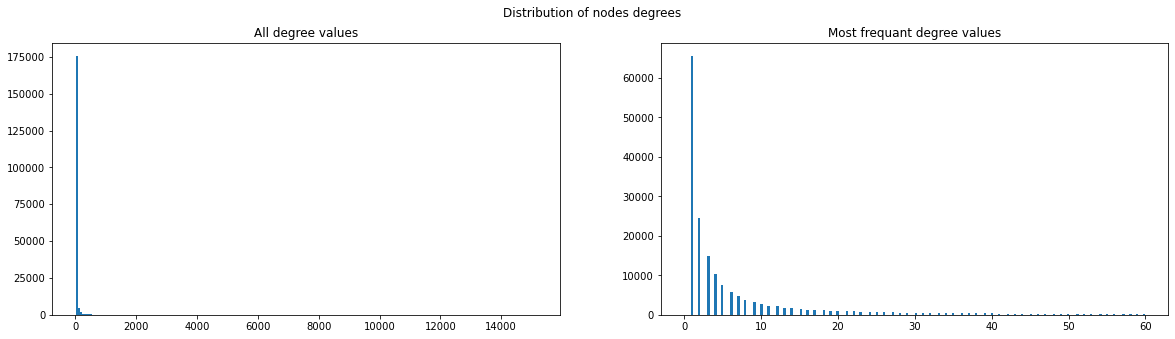

In [77]:
Visualization_1(graph)